In [1]:
import numpy as np 
import pandas as pd
import torchvision.models as models
import glob
from PIL import Image
import torch
from sklearn.manifold import TSNE
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed(2)
torch.backends.cudnn.deterministic = True
import os
print(os.listdir())

['.config', 'plates.zip', 'working', 'sample_data']


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
import zipfile
with zipfile.ZipFile('plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('working')

In [4]:
print('After zip extraction:')
print(os.listdir("working/"))

After zip extraction:
['__MACOSX', 'plates']


In [5]:
data_root = '/content/working/plates'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [6]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2616.84it/s]


In [7]:
!ls train

cleaned  dirty


In [0]:
import torchvision

In [0]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),                                   
    transforms.Grayscale(num_output_channels=3),
    

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                                 
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
   
   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [10]:
len(train_dataloader), len(train_dataset)

(4, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


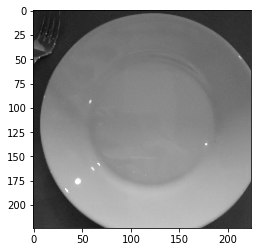

In [11]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

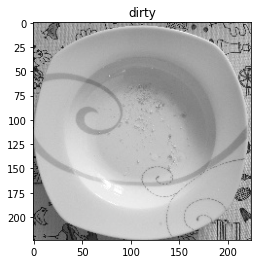

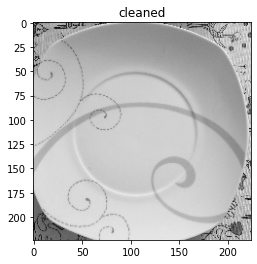

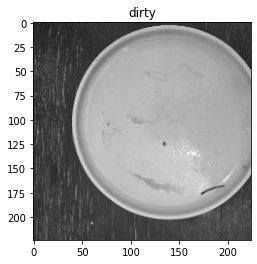

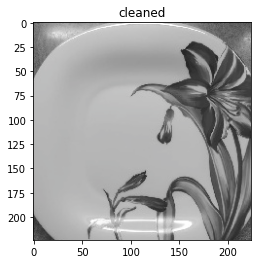

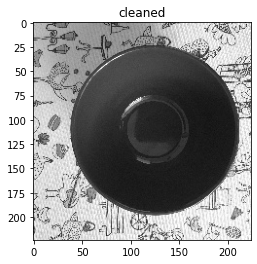

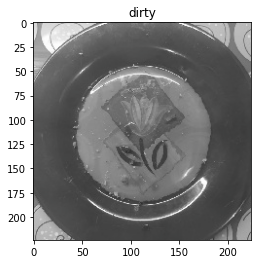

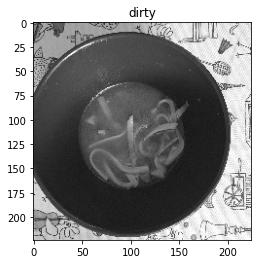

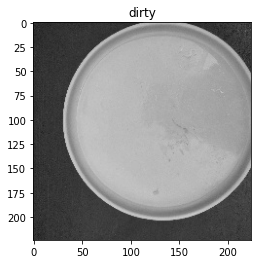

In [12]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [0]:
model = models.resnet101(pretrained=True)
# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01)

In [15]:
print(model.fc.in_features)

2048


In [16]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch 0/29:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

train Loss: 0.7219 Acc: 0.4688



100%|██████████| 1/1 [00:03<00:00,  3.12s/it]

val Loss: 0.5682 Acc: 0.6250
Epoch 1/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.6448 Acc: 0.5625



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

val Loss: 0.5263 Acc: 0.8750
Epoch 2/29:



100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

train Loss: 0.4870 Acc: 0.8438



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

val Loss: 0.6555 Acc: 0.5000
Epoch 3/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.4575 Acc: 0.8750



100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

val Loss: 0.5398 Acc: 0.6250
Epoch 4/29:



100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

train Loss: 0.4157 Acc: 0.8125



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

val Loss: 0.4930 Acc: 0.7500
Epoch 5/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.3678 Acc: 0.9062



100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

val Loss: 0.6056 Acc: 0.6250
Epoch 6/29:



100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

train Loss: 0.3312 Acc: 0.9688



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

val Loss: 0.6086 Acc: 0.6250
Epoch 7/29:



100%|██████████| 4/4 [00:13<00:00,  3.40s/it]

train Loss: 0.3160 Acc: 0.9375



100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

val Loss: 0.6147 Acc: 0.6250
Epoch 8/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.3826 Acc: 0.8750



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

val Loss: 0.6158 Acc: 0.6250
Epoch 9/29:



100%|██████████| 4/4 [00:13<00:00,  3.40s/it]

train Loss: 0.3556 Acc: 0.9062



100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

val Loss: 0.6273 Acc: 0.6250
Epoch 10/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.3315 Acc: 1.0000



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

val Loss: 0.6375 Acc: 0.6250
Epoch 11/29:



100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

train Loss: 0.3710 Acc: 0.8750



100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

val Loss: 0.6155 Acc: 0.6250
Epoch 12/29:



100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

train Loss: 0.3392 Acc: 1.0000



100%|██████████| 1/1 [00:03<00:00,  3.05s/it]

val Loss: 0.6304 Acc: 0.6250
Epoch 13/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.4080 Acc: 0.8750



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

val Loss: 0.6502 Acc: 0.6250
Epoch 14/29:



100%|██████████| 4/4 [00:13<00:00,  3.39s/it]

train Loss: 0.3065 Acc: 0.9688



100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

val Loss: 0.6529 Acc: 0.6250
Epoch 15/29:



100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

train Loss: 0.3320 Acc: 0.9062



100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

val Loss: 0.6505 Acc: 0.5000
Epoch 16/29:



100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

train Loss: 0.3491 Acc: 0.9688



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

val Loss: 0.6364 Acc: 0.5000
Epoch 17/29:



100%|██████████| 4/4 [00:13<00:00,  3.41s/it]

train Loss: 0.2623 Acc: 1.0000



100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

val Loss: 0.6334 Acc: 0.5000
Epoch 18/29:



100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

train Loss: 0.3307 Acc: 0.9375



100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

val Loss: 0.6338 Acc: 0.5000
Epoch 19/29:



100%|██████████| 4/4 [00:13<00:00,  3.36s/it]

train Loss: 0.3214 Acc: 0.9688



100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

val Loss: 0.6224 Acc: 0.5000
Epoch 20/29:



100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

train Loss: 0.3332 Acc: 0.9688



100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

val Loss: 0.6318 Acc: 0.5000
Epoch 21/29:



100%|██████████| 4/4 [00:13<00:00,  3.37s/it]

train Loss: 0.3198 Acc: 0.9688



100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

val Loss: 0.6258 Acc: 0.5000
Epoch 22/29:



100%|██████████| 4/4 [00:17<00:00,  4.41s/it]

train Loss: 0.2982 Acc: 1.0000



100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

val Loss: 0.6308 Acc: 0.5000
Epoch 23/29:



 25%|██▌       | 1/4 [00:06<00:18,  6.27s/it]


KeyboardInterrupt: ignored

In [17]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [19]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
   
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [03:59<00:00,  2.57s/it]


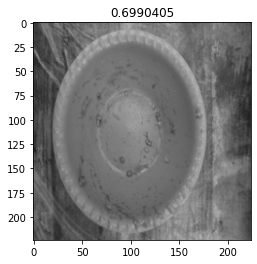

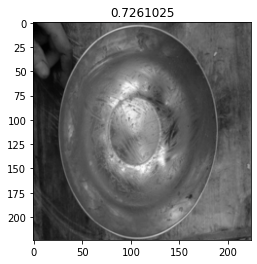

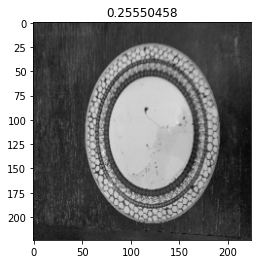

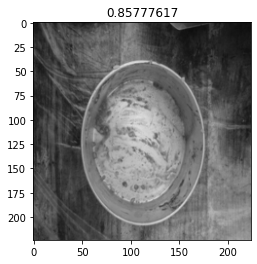

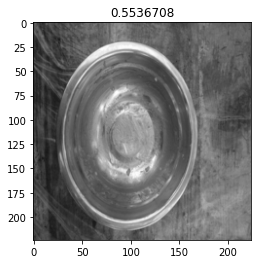

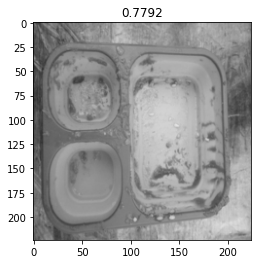

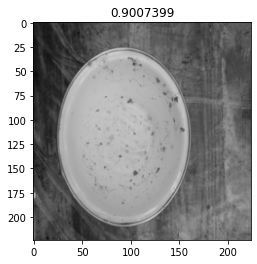

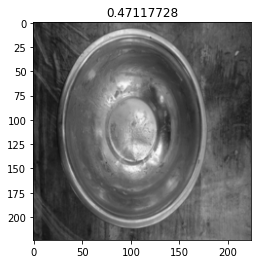

In [21]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [0]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [23]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [0]:
submission_df.to_csv('submission.csv')

In [0]:
!rm -rf train val test